# **Alzheimer Prediction with MR Images** 

## *About the Dataset*

* Total 6400 images belongs to 4 different classes:

    - Mild Demented
    - Moderate Demented
    - Non Demented
    - Very Mild Demented


## *Importing required packages*

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## *Dataset Distribution*

A search has been initiated within the folder named 'Dataset'.
There are 896 images in the Mild_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 3200 images in the Non_Demented folder.
There are 2240 images in the Very_Mild_Demented folder.
The search has been completed.


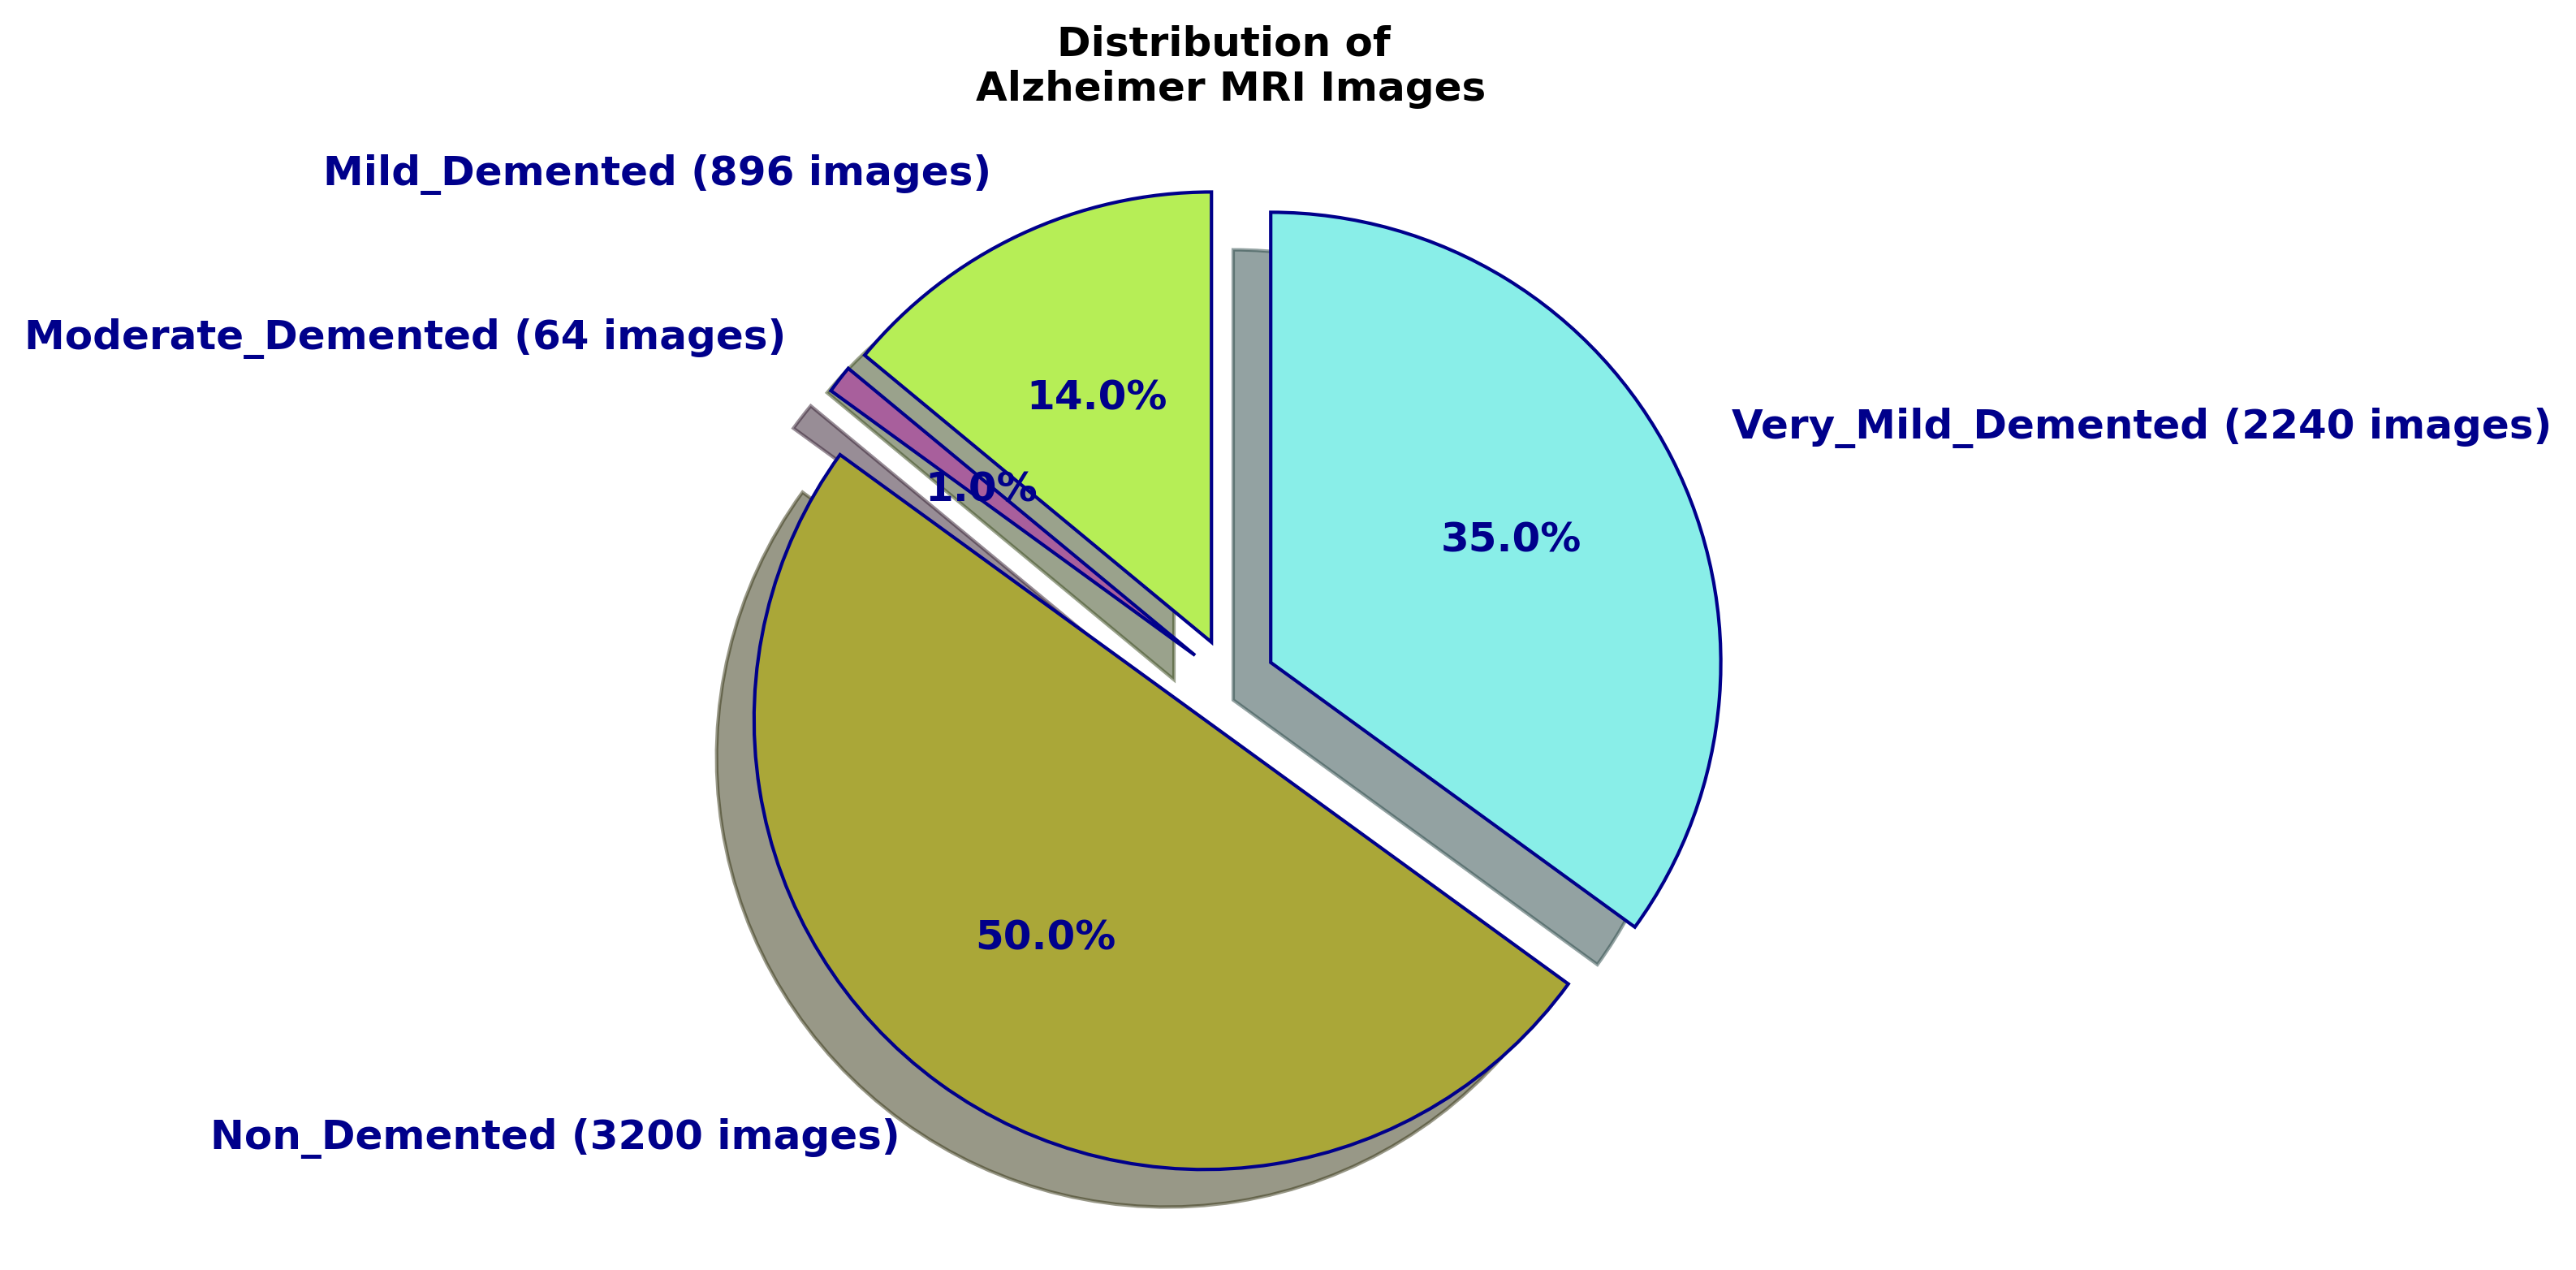

In [33]:
class_dist = {}
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#A85F9C", "#AAA738", "#89EEE8"]
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1
            
            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')
    
    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)
    
    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]
    
    plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors, textprops={'fontsize': 12, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
           {'edgecolor':'darkblue'} , labeldistance=1.15)
    plt.title("Distribution of \nAlzheimer MRI Images", size=12, fontweight="bold")

PATH = 'Dataset'

image_counter(PATH)

* Moderate Demented class has very less images when comapred with others, this indicates a imbalance in the dataset.

## *Creating Tensorflow Dataset*

In [34]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names
class_names

Found 6400 files belonging to 4 classes.


['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

### *Samples for each class*

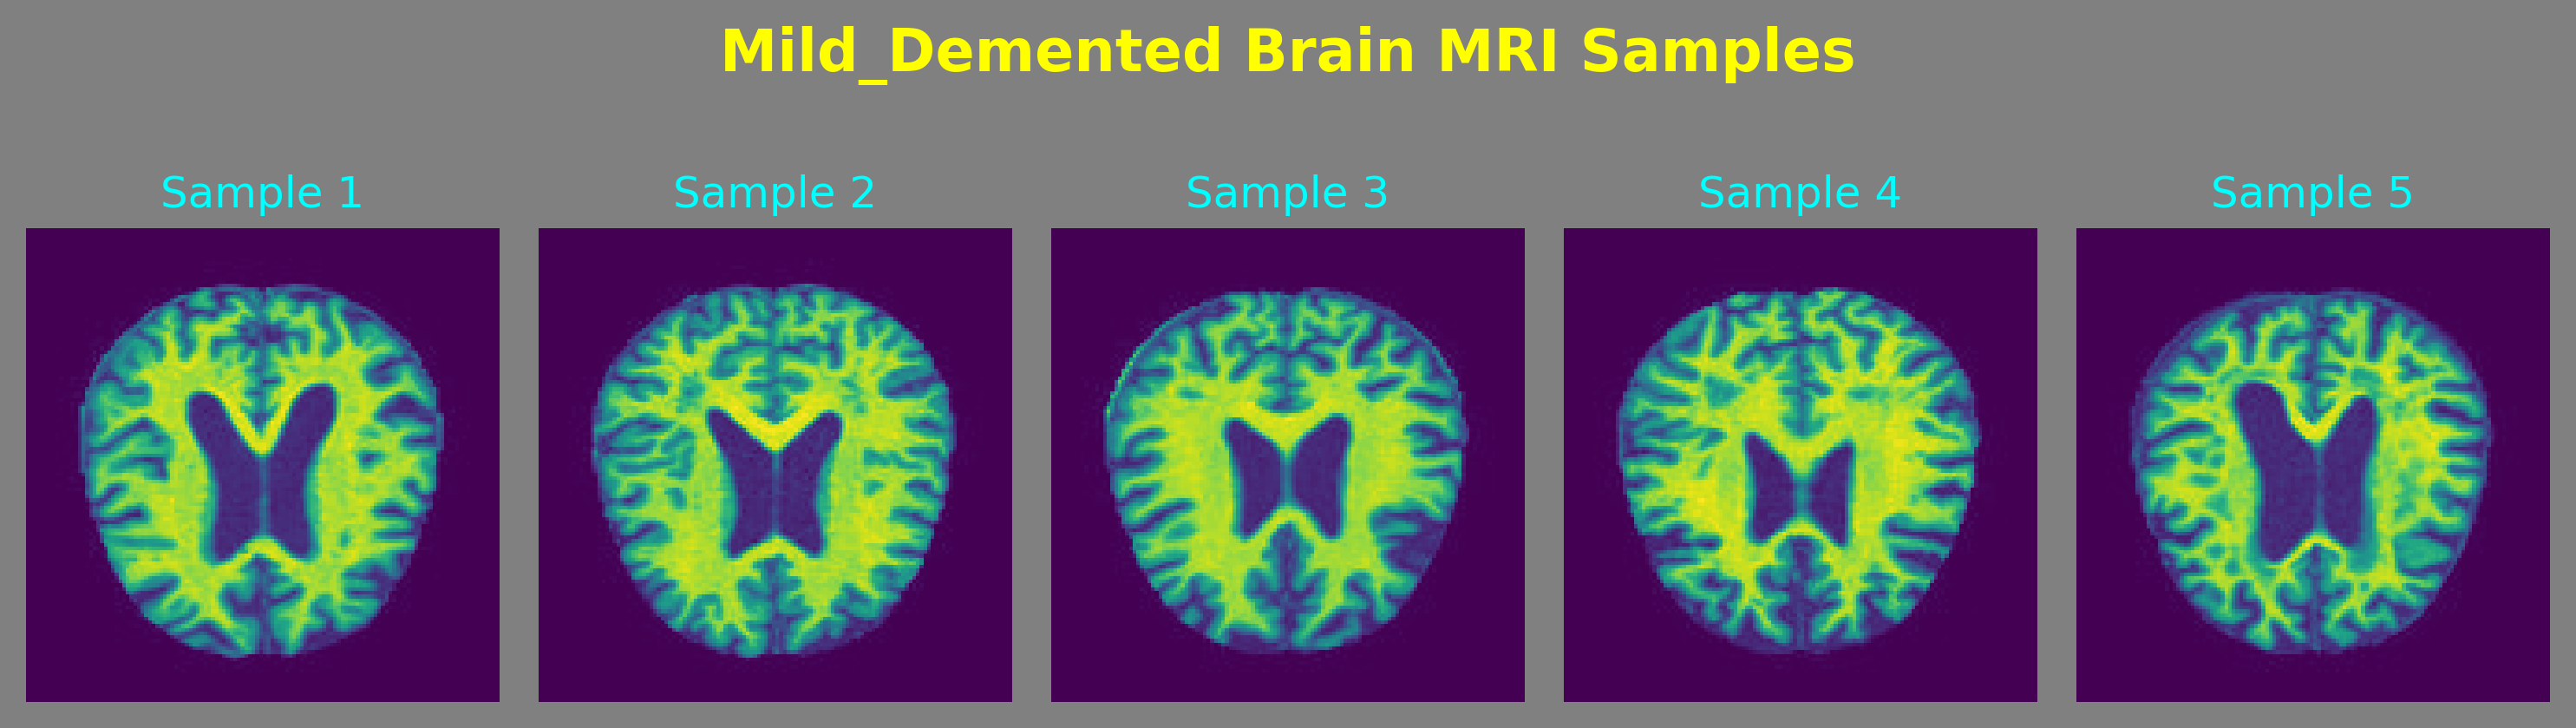

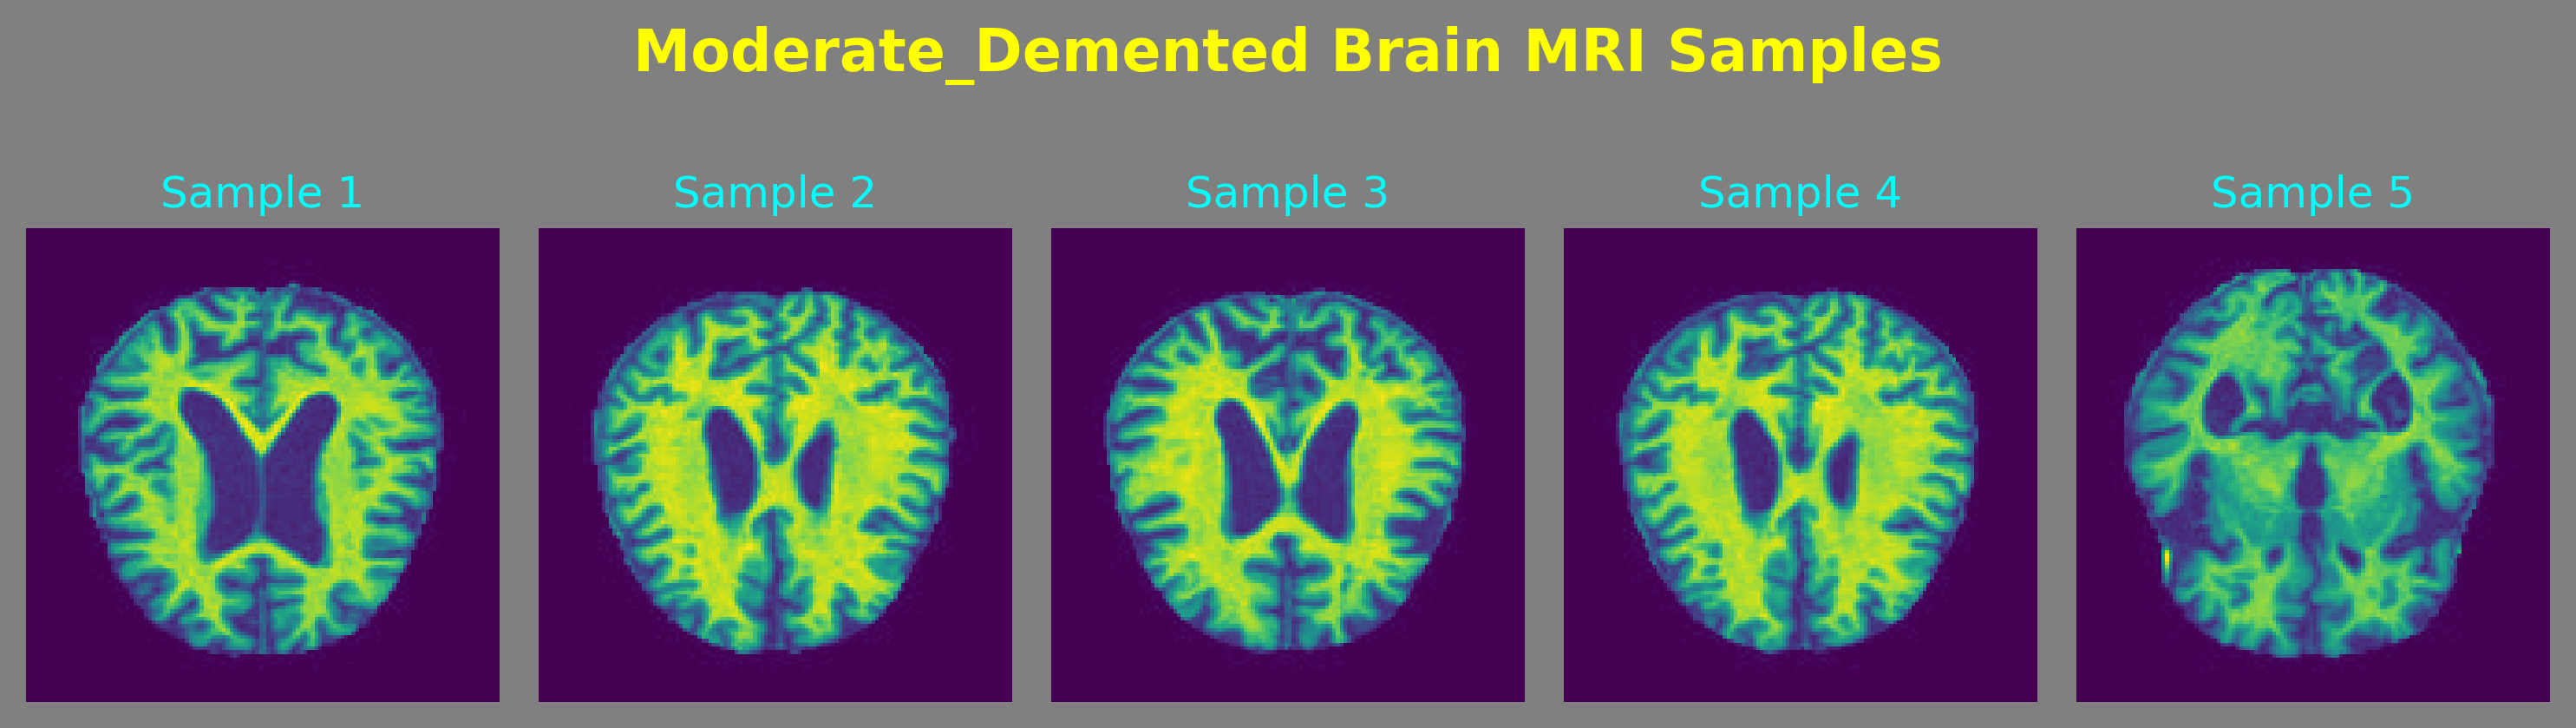

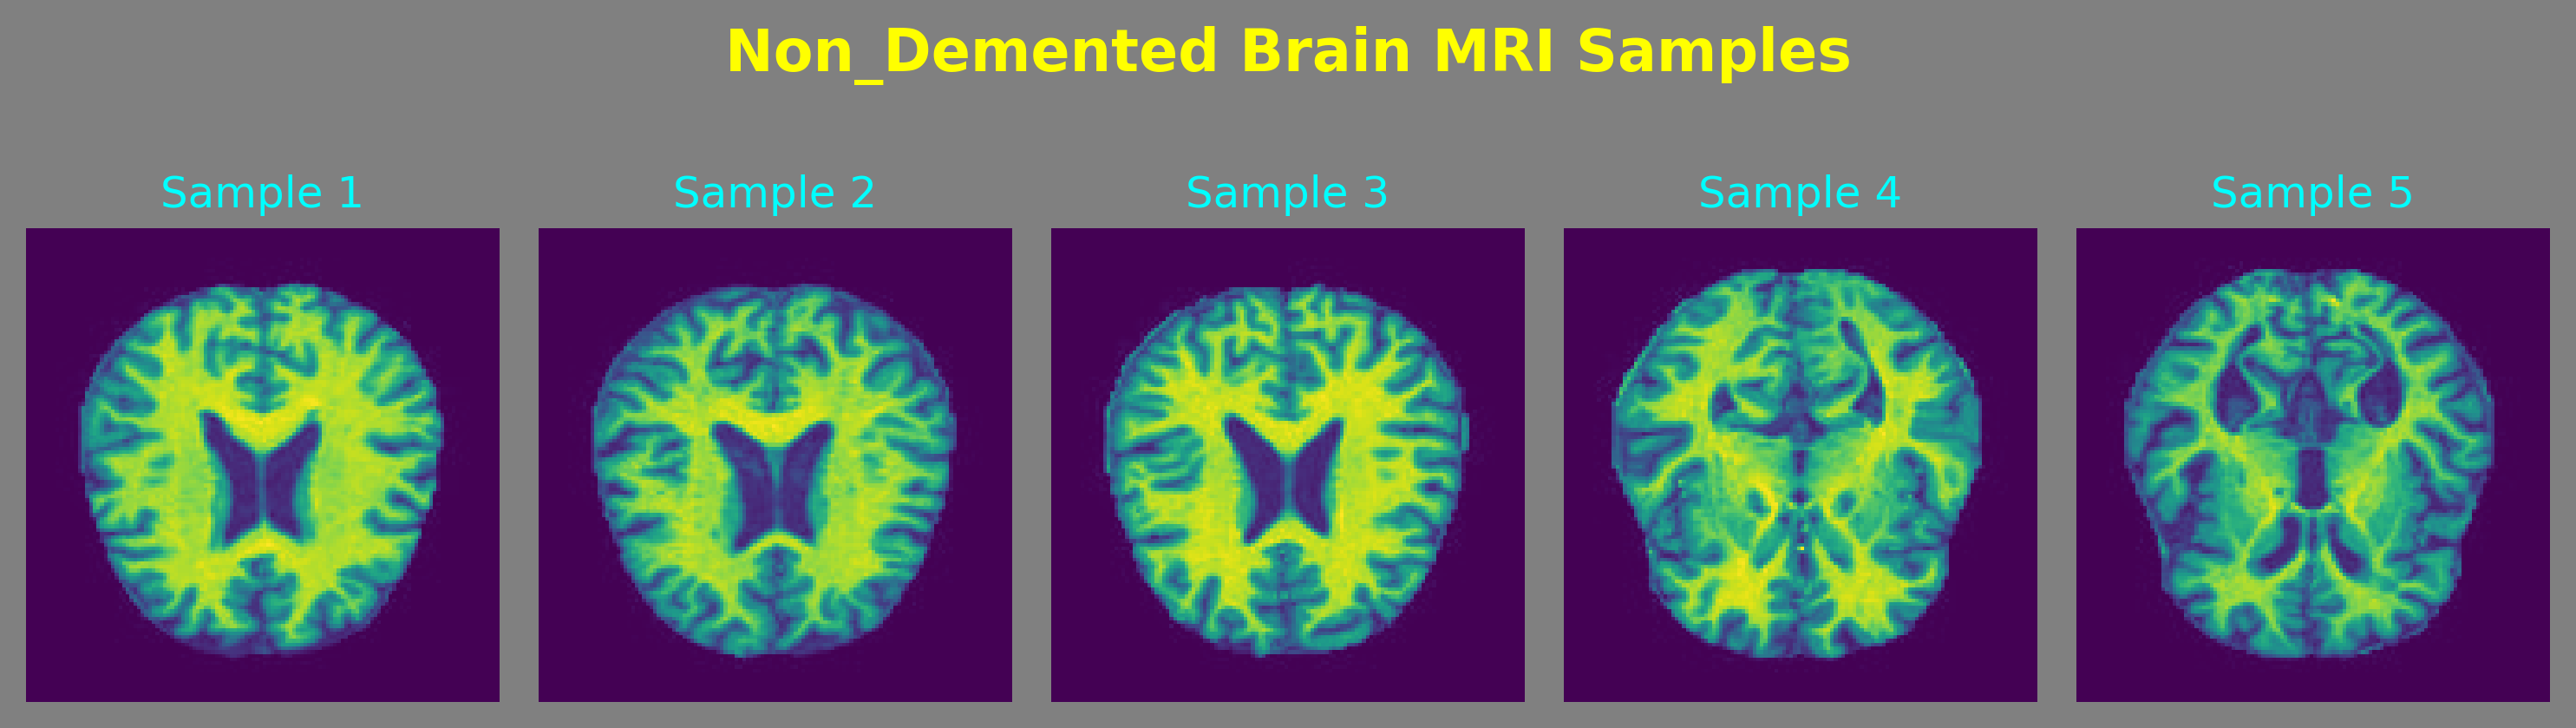

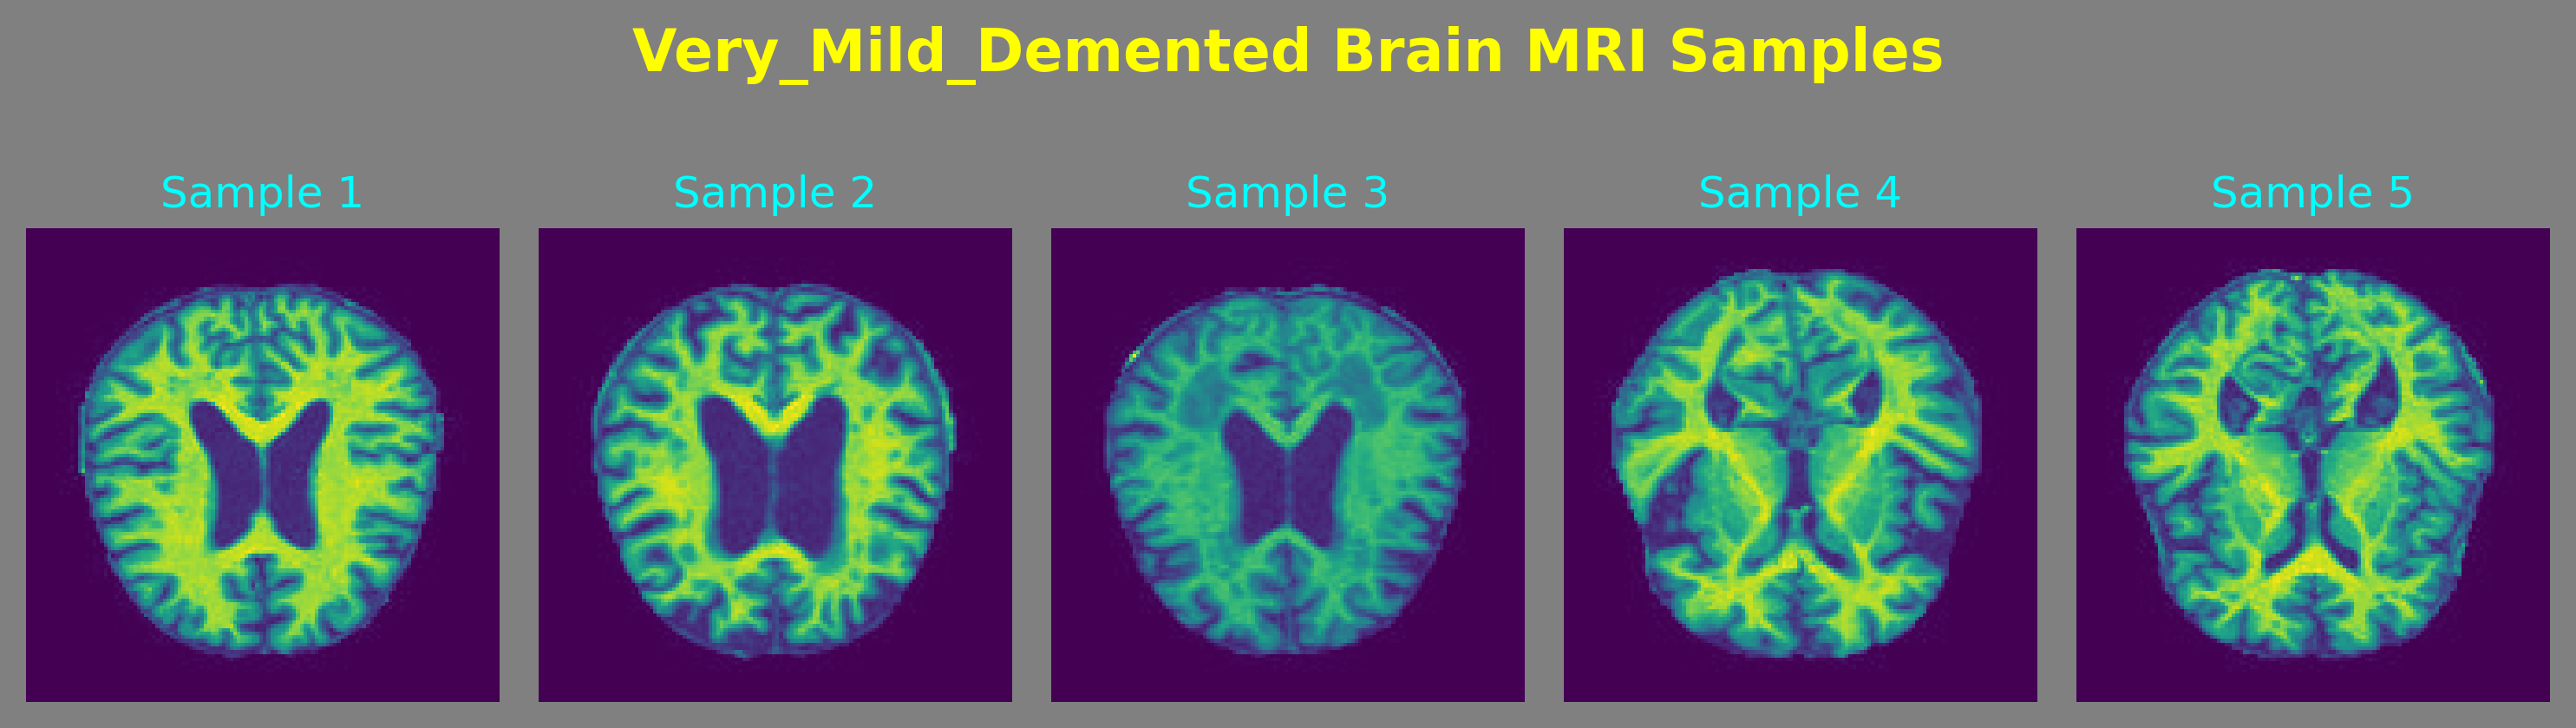

In [35]:
def sample_bringer(path, target, num_samples=5):
    
    class_path = os.path.join(path, target)

    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="gray")
    fig.suptitle(f'{target} Brain MRI Samples', color="yellow",fontsize=16, fontweight='bold', y=0.75)
    
    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="aqua")

    plt.tight_layout()
    
for target in class_names:
    sample_bringer(PATH, target=target)

In [36]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())
        
    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="yellow",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])
    
    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)
        
        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

Min and max pixel values in the batch -> 0.0 & 1.0


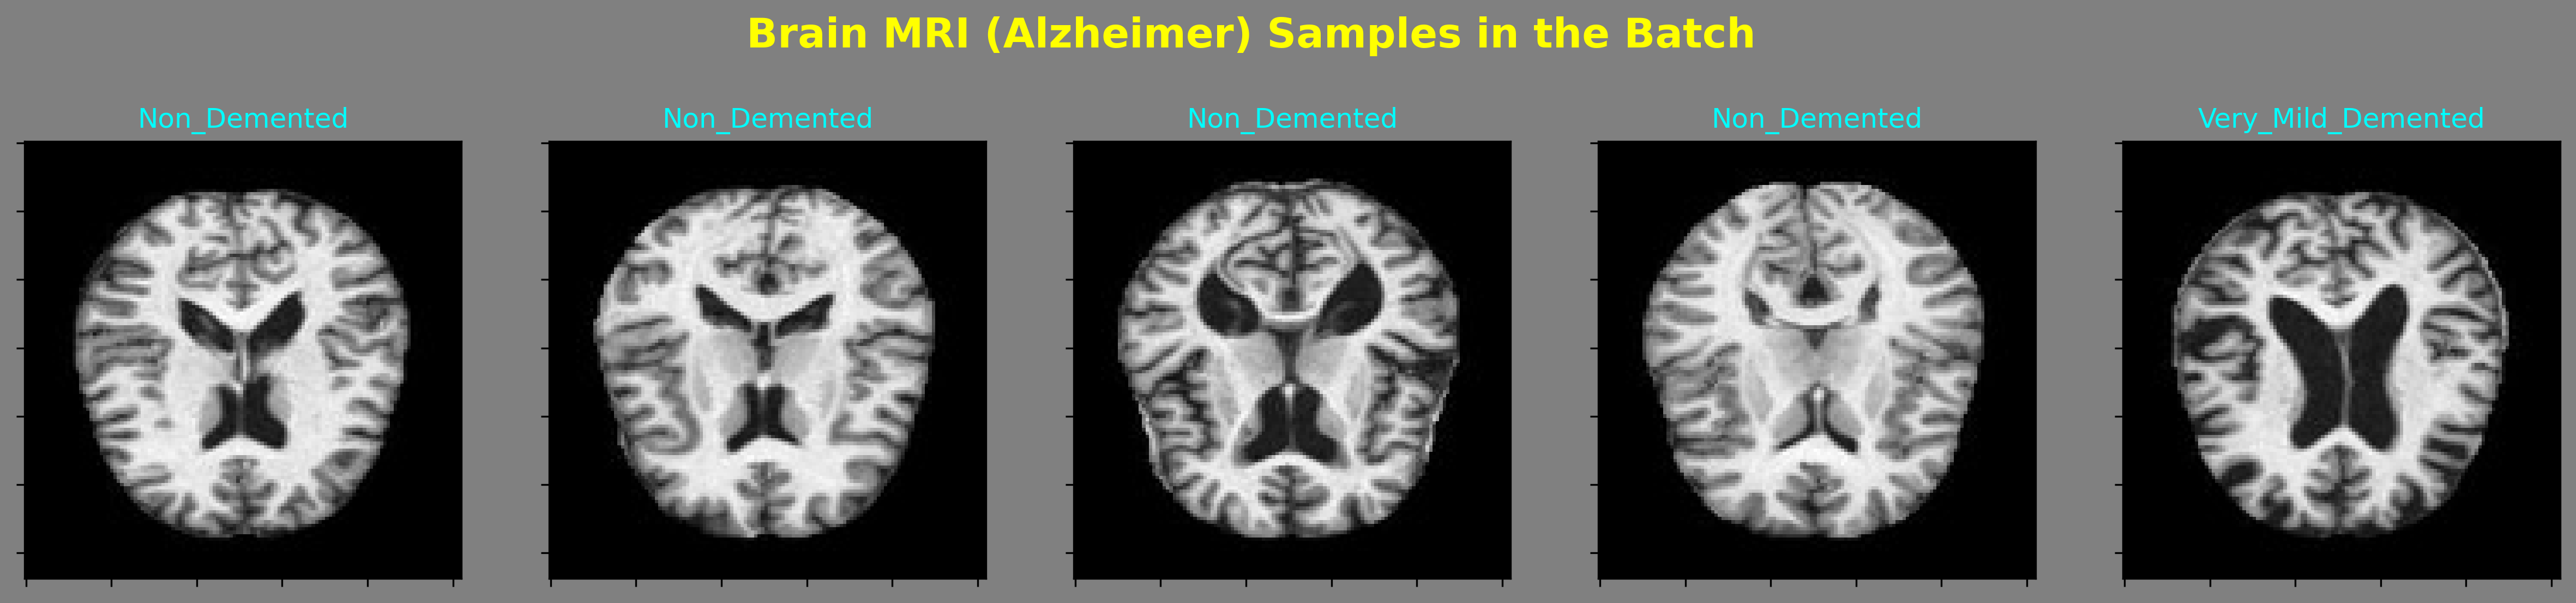

In [37]:
process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

#### Dataset Splitting

In [38]:
train_data, val_data, test_data= process.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)

In [39]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

## *Model Building*

In [40]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
    model.summary()
    
    return model

model = build_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 128)     

## *Model Callback*

In [41]:
checkpoint_filepath = 'best_model_model1_copy.hdf5' 

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor="val_loss",
        mode='min')
]

In [42]:
history = model.fit(train_data, 
            epochs = 30, 
            validation_data = val_data,
            class_weight = class_weights, 
            callbacks = callbacks)

Epoch 1/30


160/160 [==============================] - 31s 183ms/step - loss: 1.5350 - accuracy: 0.2443 - val_loss: 1.3122 - val_accuracy: 0.3516
Epoch 2/30
160/160 [==============================] - 28s 176ms/step - loss: 1.1702 - accuracy: 0.4812 - val_loss: 1.7160 - val_accuracy: 0.2094
Epoch 3/30
160/160 [==============================] - 29s 180ms/step - loss: 0.7784 - accuracy: 0.5914 - val_loss: 0.6461 - val_accuracy: 0.6984
Epoch 4/30
160/160 [==============================] - 29s 181ms/step - loss: 0.3672 - accuracy: 0.7768 - val_loss: 0.9494 - val_accuracy: 0.6141
Epoch 5/30
160/160 [==============================] - 29s 182ms/step - loss: 0.1779 - accuracy: 0.8988 - val_loss: 0.1877 - val_accuracy: 0.9344
Epoch 6/30
160/160 [==============================] - 29s 181ms/step - loss: 0.0541 - accuracy: 0.9742 - val_loss: 0.1165 - val_accuracy: 0.9719
Epoch 7/30
160/160 [==============================] - 29s 180ms/step - loss: 0.0219 - accuracy: 0.9918 - val_loss: 0.0818 - val_accuracy: 0.9

## *Loss & Accuracy*

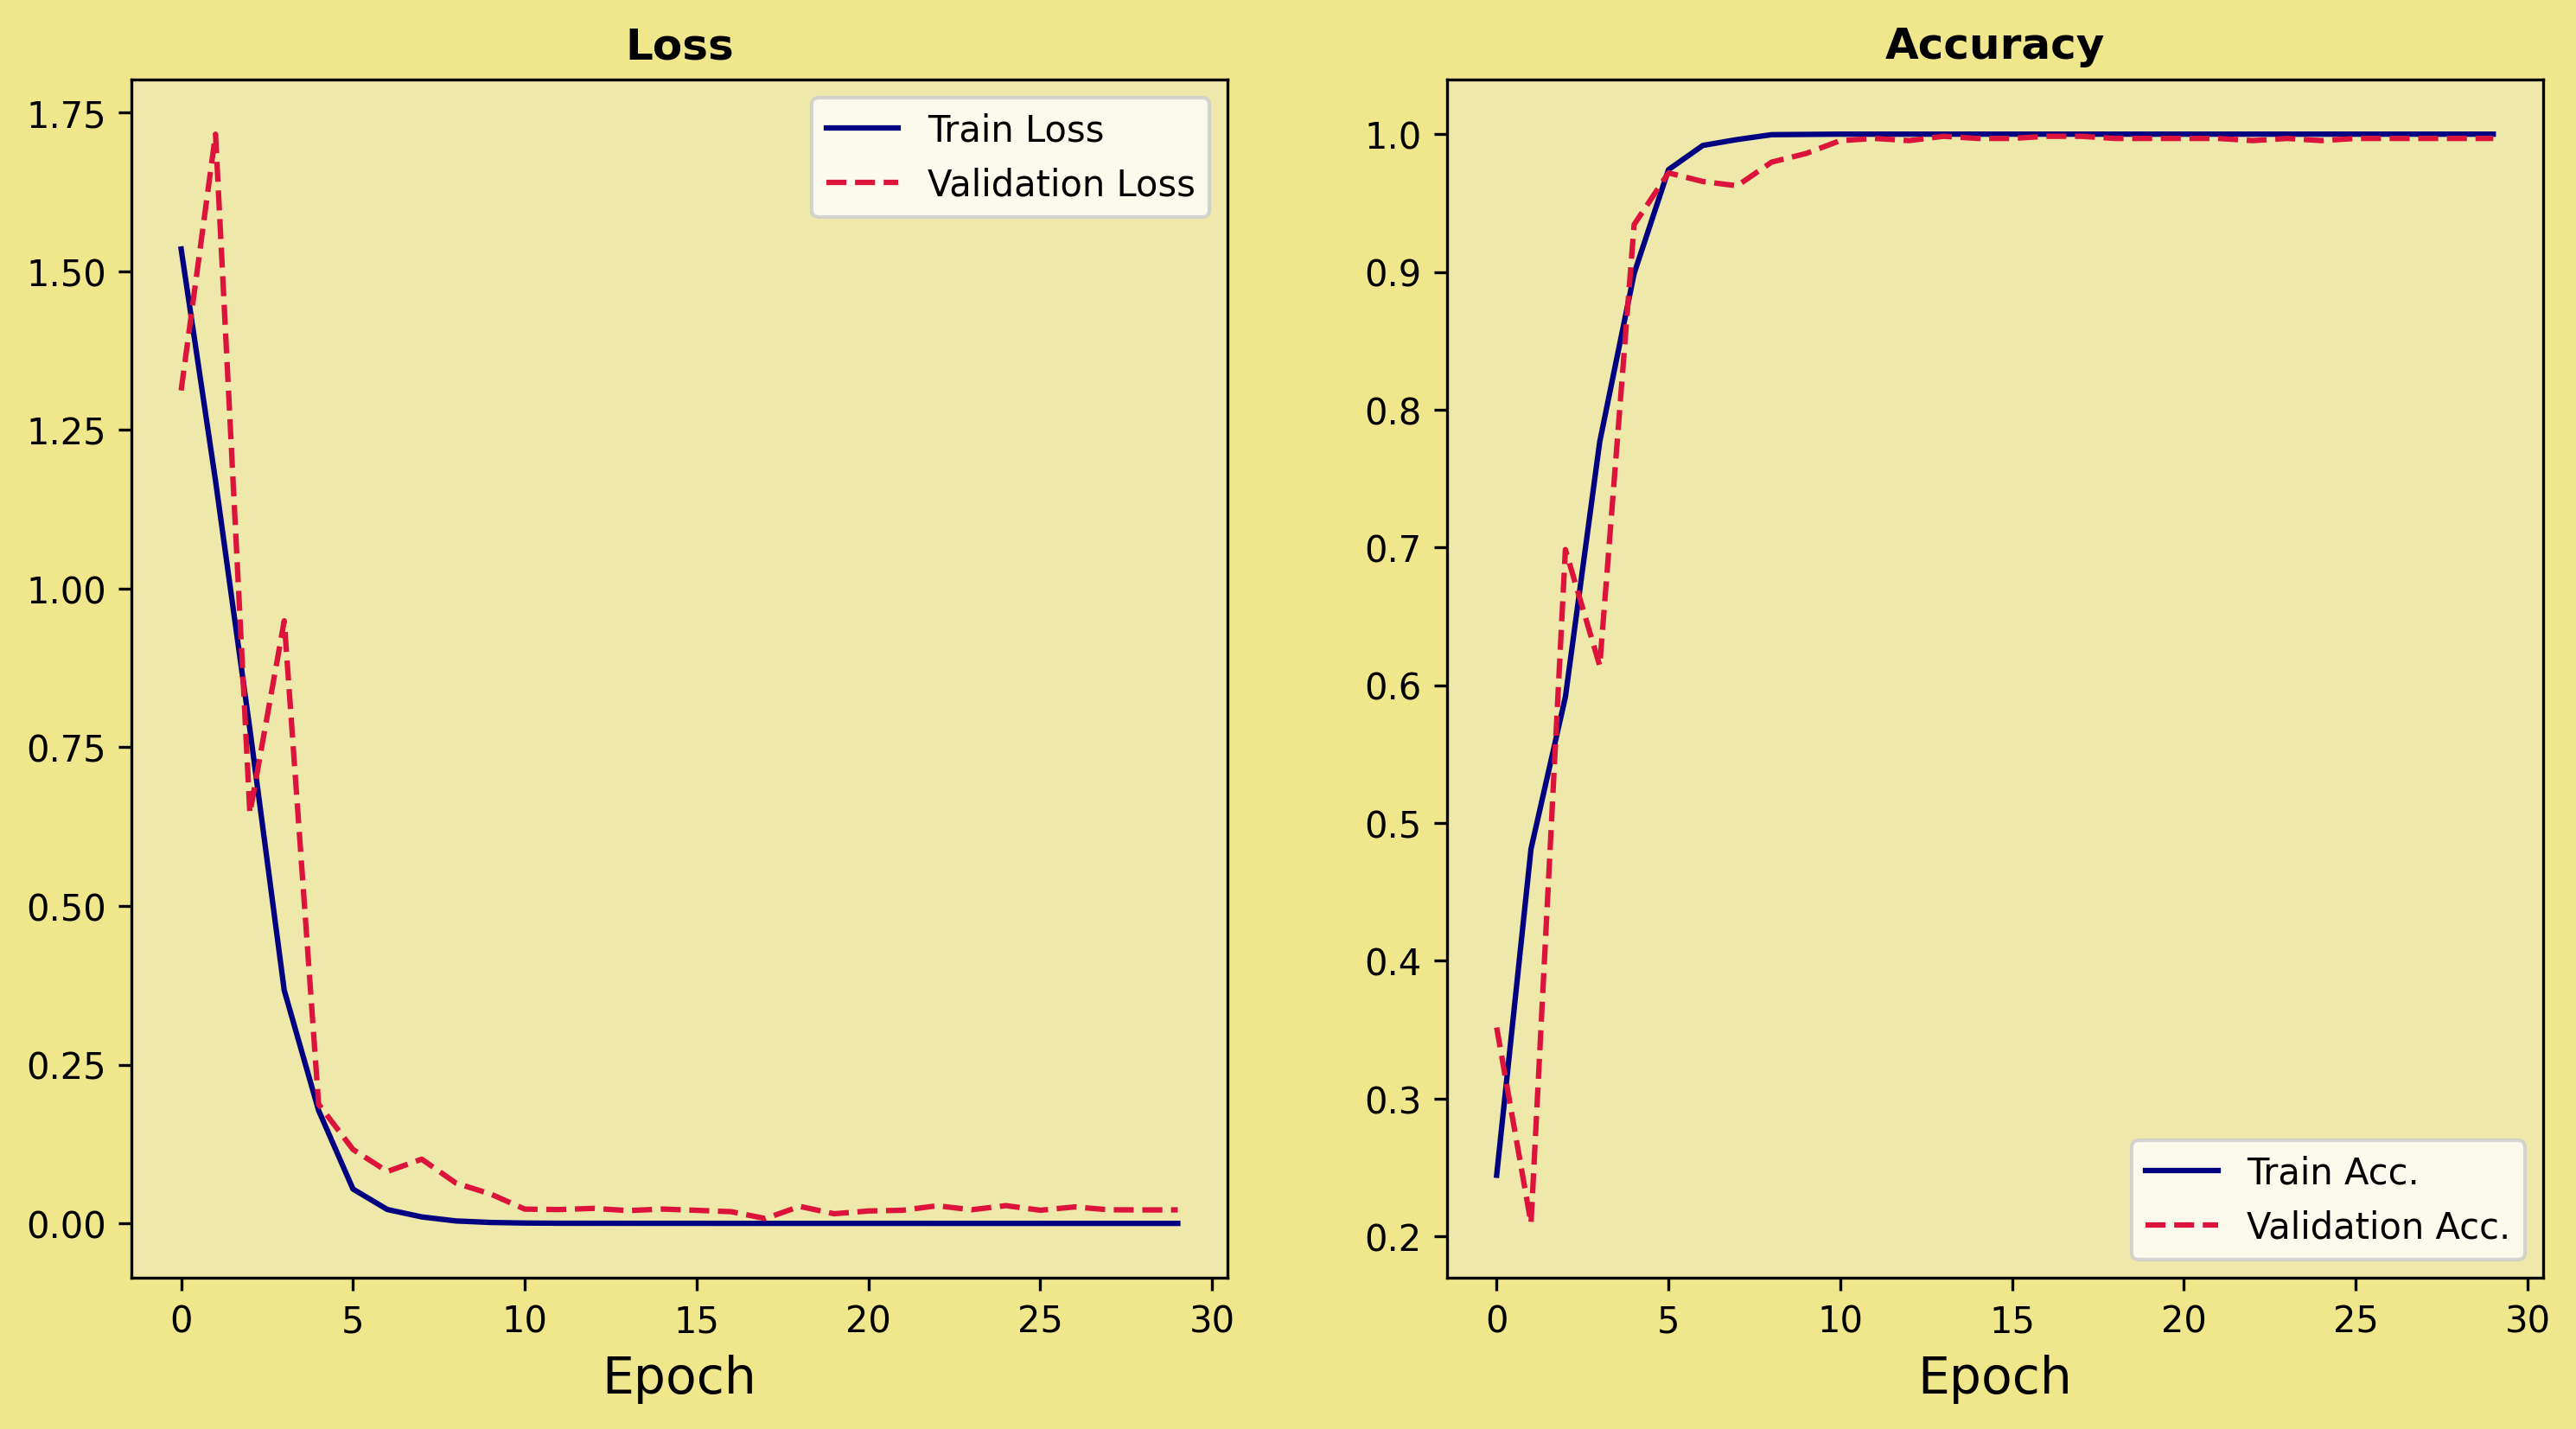

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')  
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

## *Evaluating with test Data*

In [44]:
model.evaluate(test_data)

20/20 [==============================] - 4s 68ms/step - loss: 0.0282 - accuracy: 0.9906


[0.02817031741142273, 0.9906250238418579]

## *Classification Report*

In [45]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)
    
predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.97      0.99        80
 Moderate_Demented       1.00      1.00      1.00         4
      Non_Demented       0.99      1.00      1.00       319
Very_Mild_Demented       0.99      0.99      0.99       237

          accuracy                           0.99       640
         macro avg       1.00      0.99      0.99       640
      weighted avg       0.99      0.99      0.99       640



## *Confusion Matrix*

Text(286.1666666666666, 0.5, 'True')

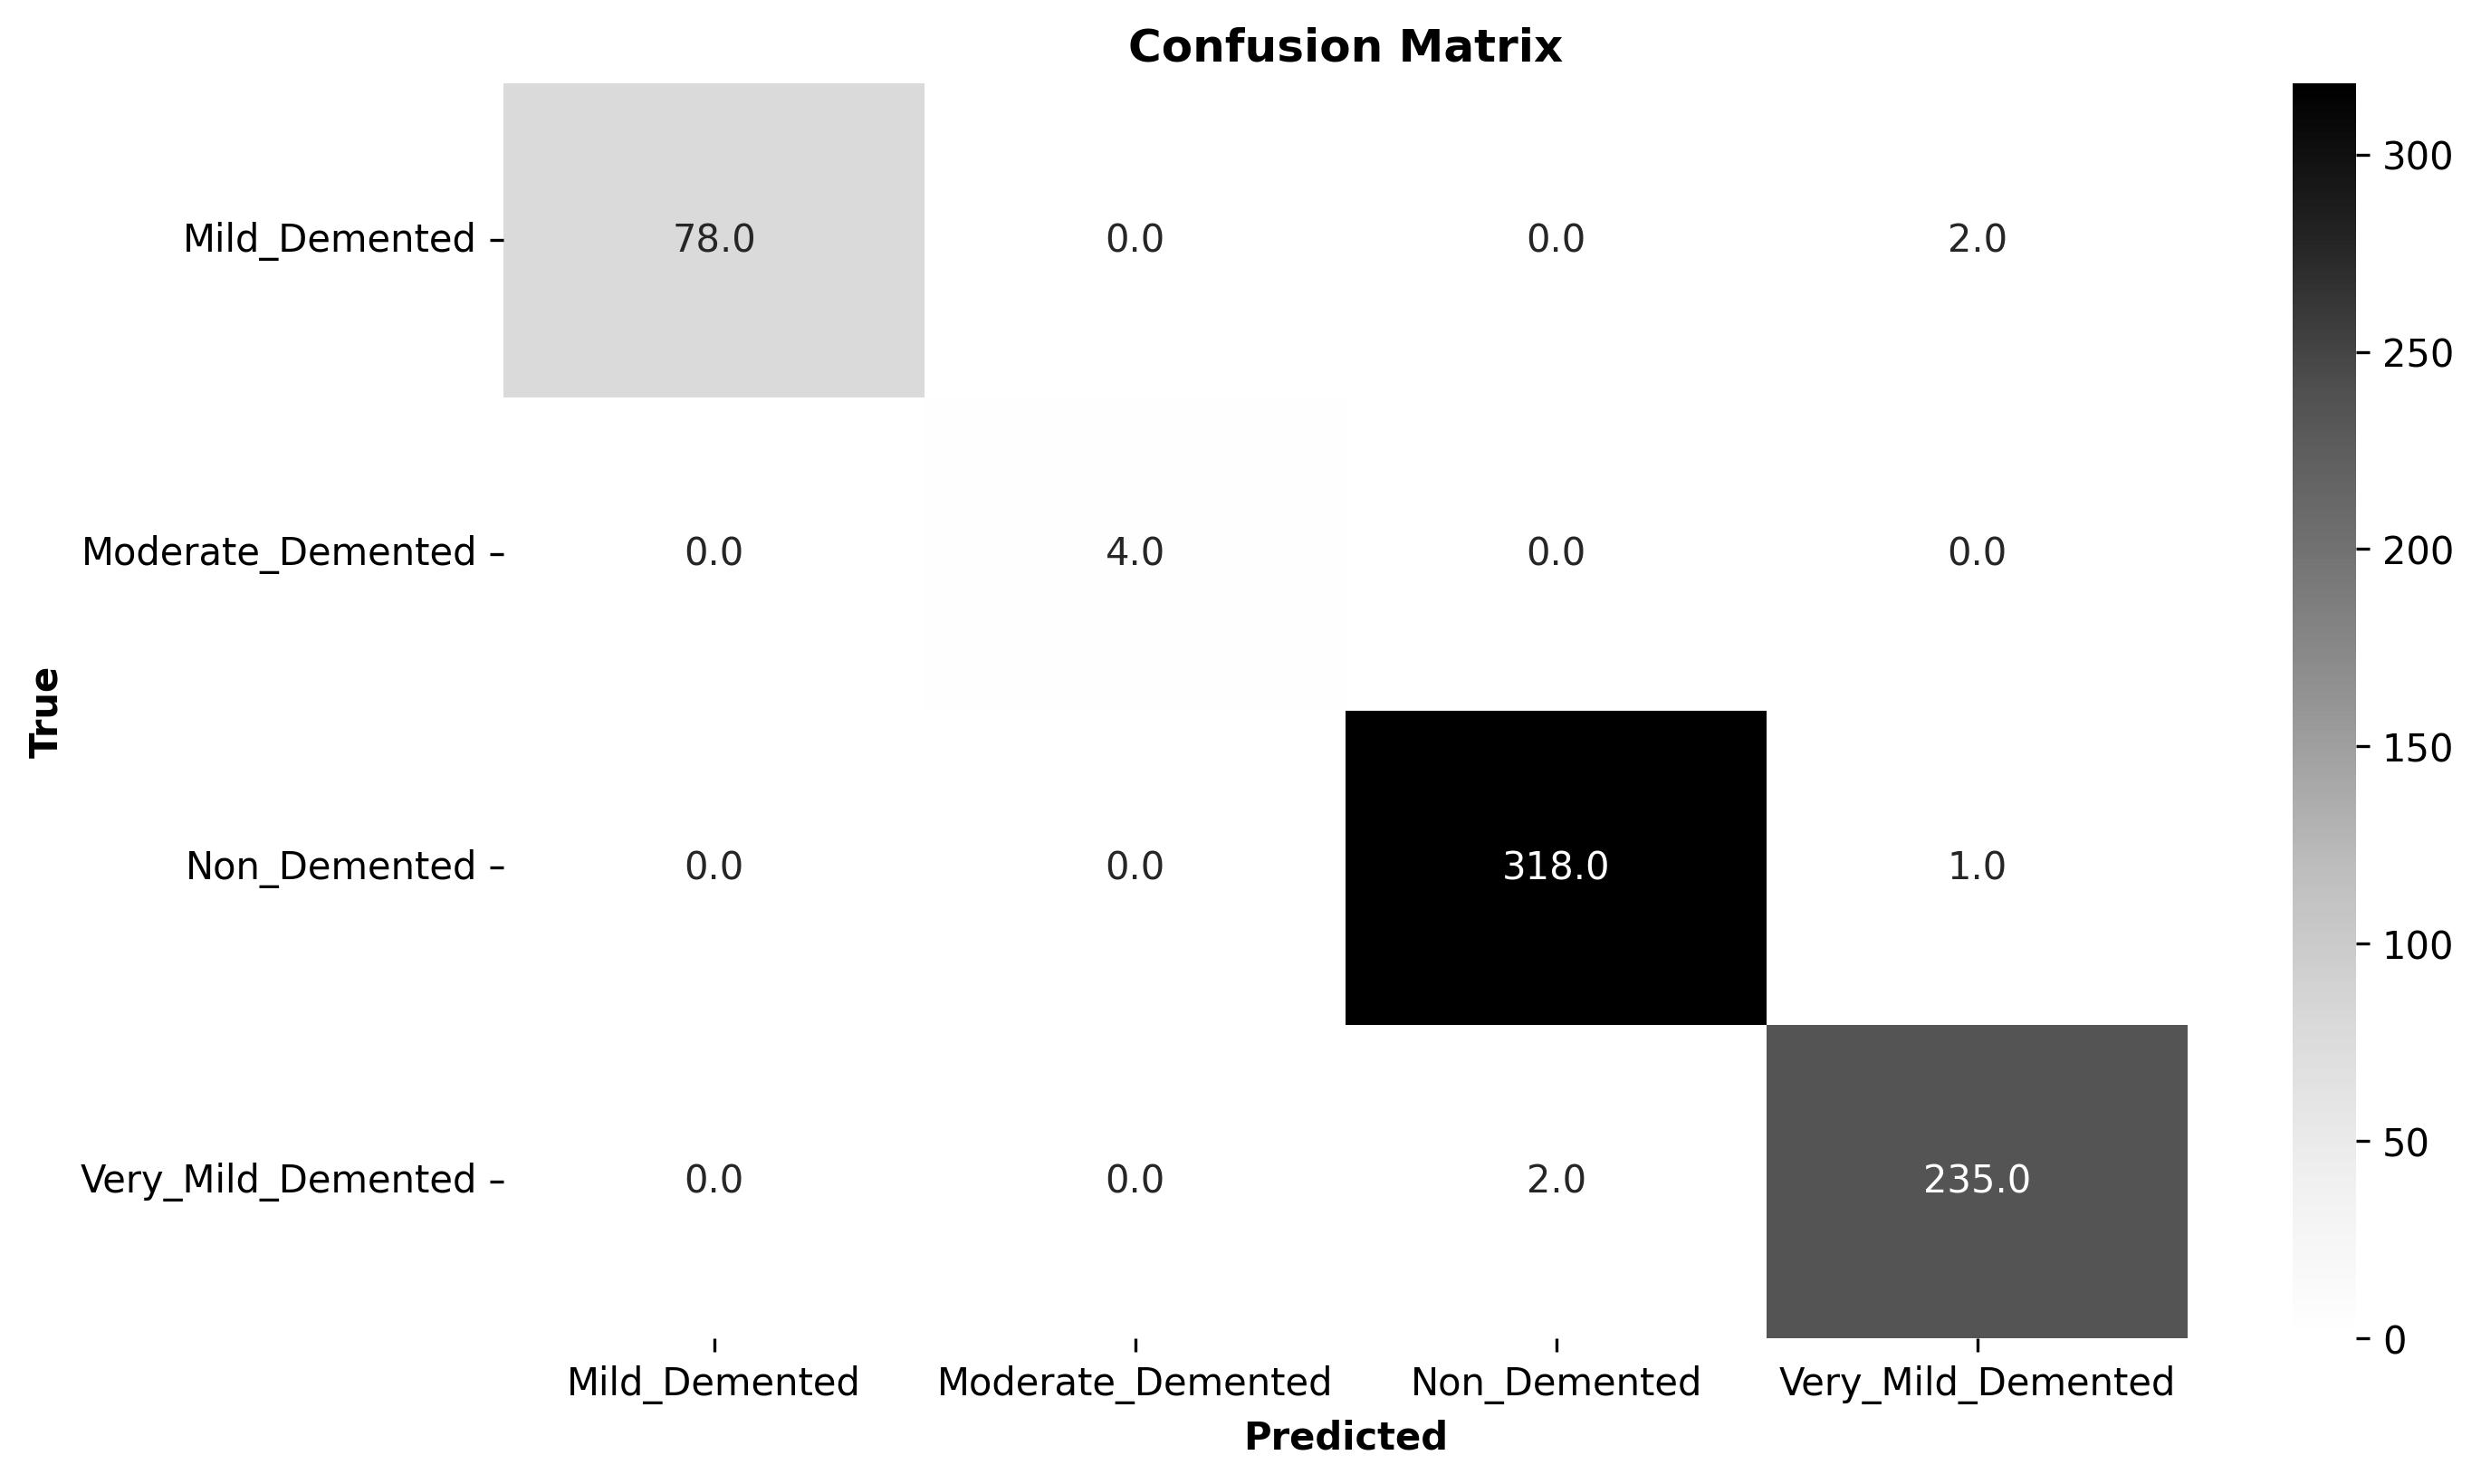

In [46]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

## *Alzheimer Probability*

1/1 [==============================] - 0s 188ms/step


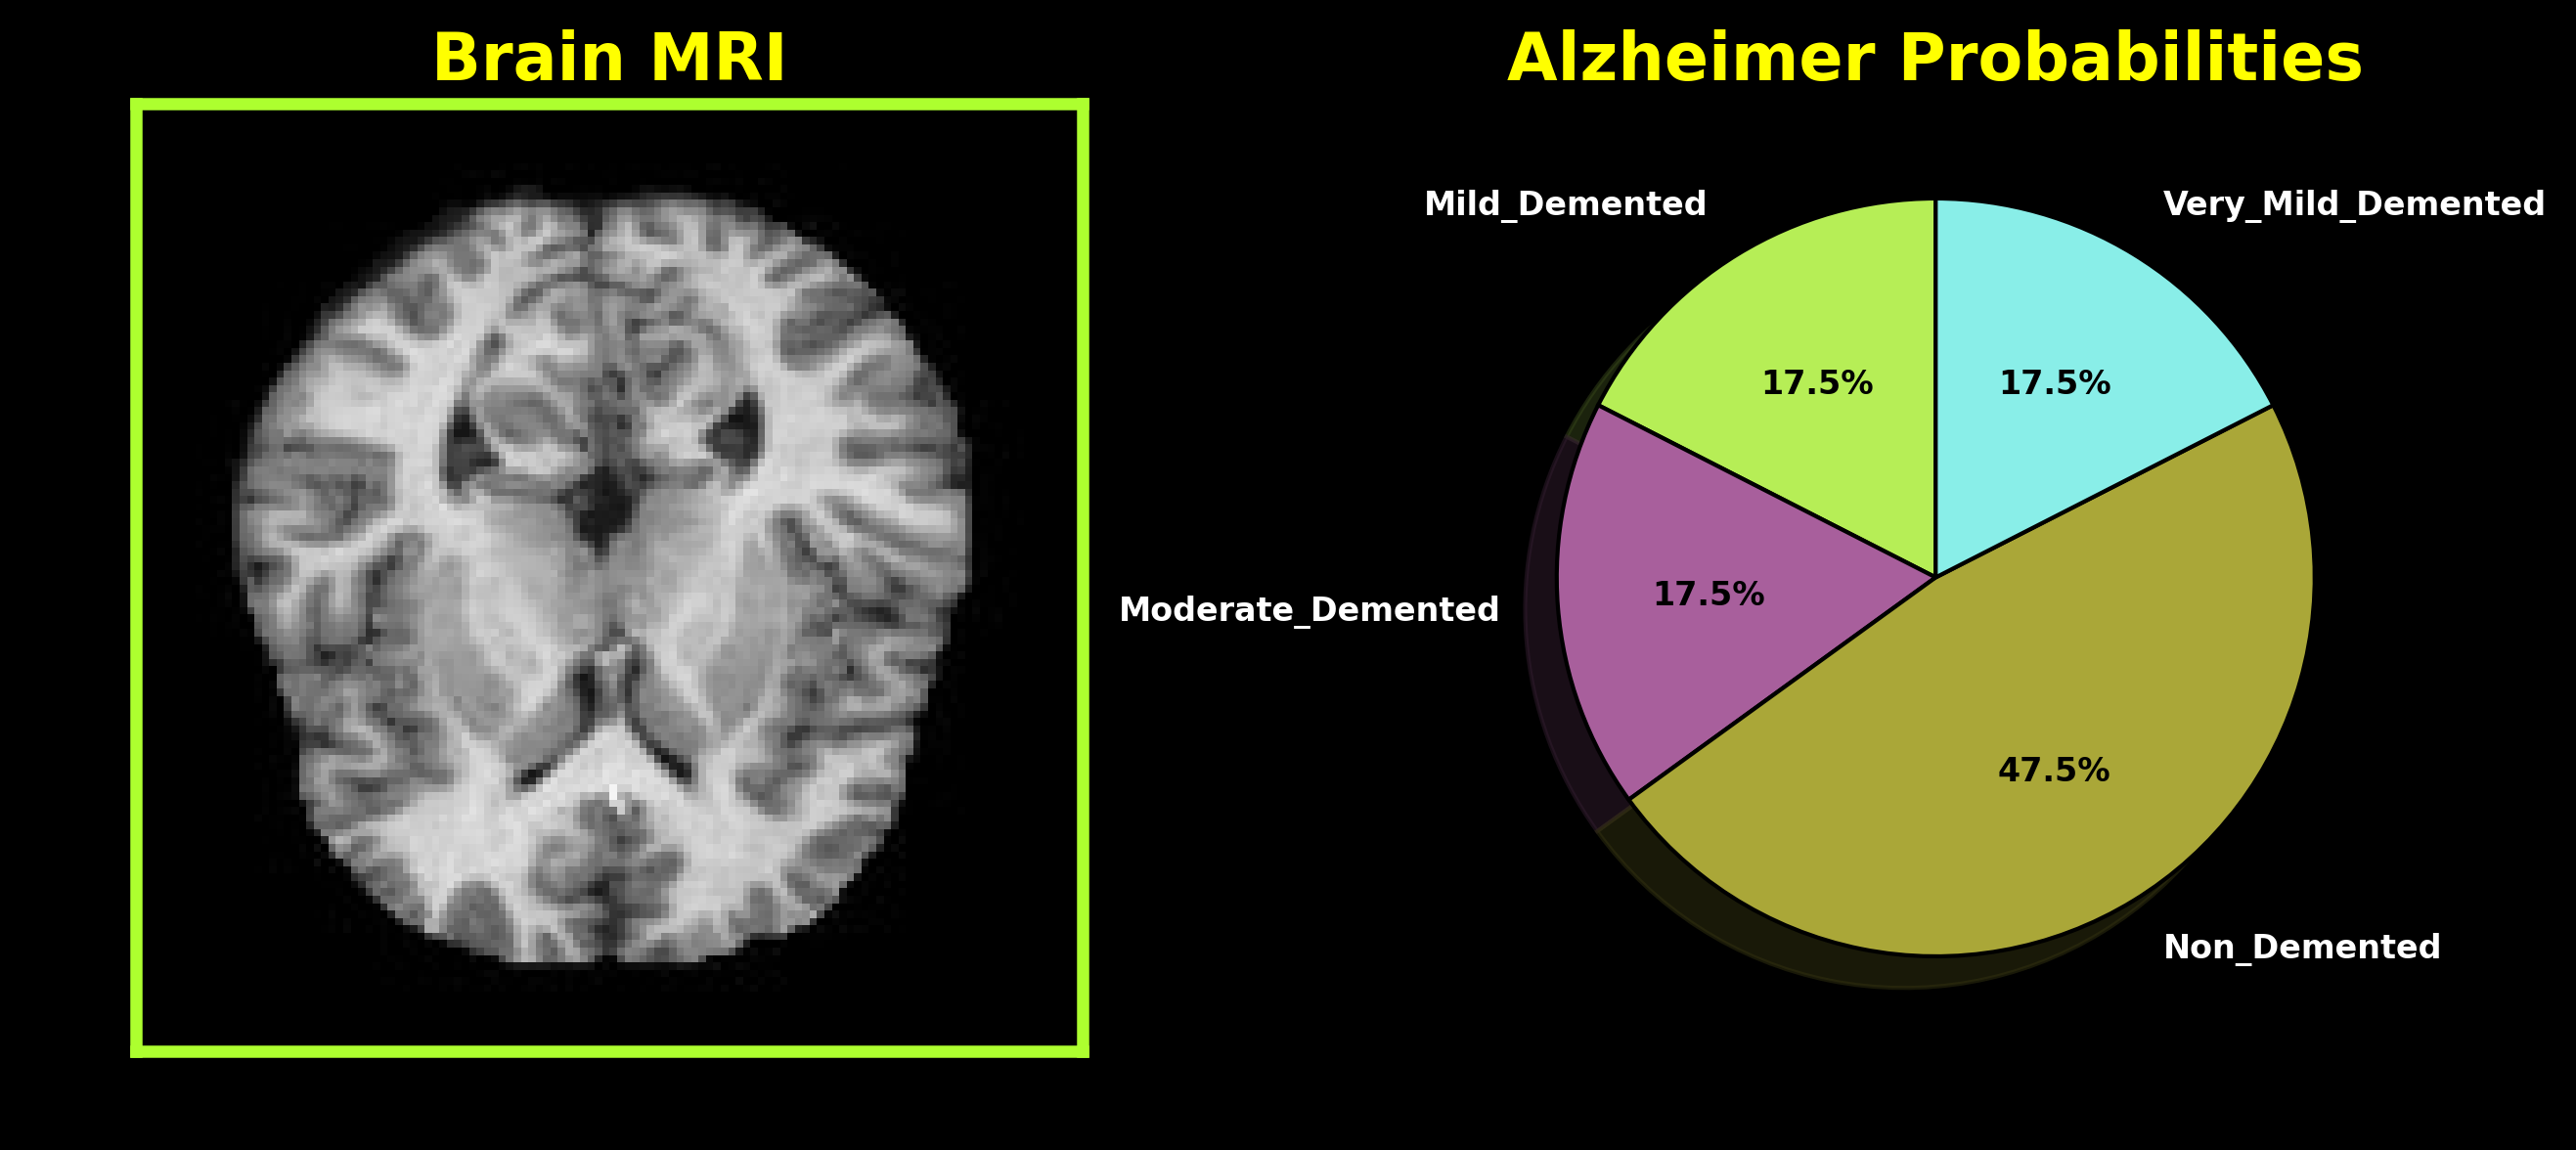

In [47]:
def random_mri_prob_bringer(image_number=0):
    
    for images, _ in test_data.skip(5).take(1):
        image = images[image_number]
        pred = model.predict(tf.expand_dims(image, 0))[0]
        
    probs = list(tf.nn.softmax(pred).numpy()) 
    probs_dict = dict(zip(class_dist.keys(), probs))
    
    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4) 
    ax1.imshow(image)
    ax1.set_title('Brain MRI', color="yellow", fontweight="bold", fontsize=16)
    
    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])        
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('Alzheimer Probabilities', color="yellow", fontweight="bold", fontsize=16)
    
rand_img_no = np.random.randint(1, 32)
random_mri_prob_bringer(image_number=rand_img_no)

## *Comparing Predicted Classes with the Actual Classes from the Test Data*

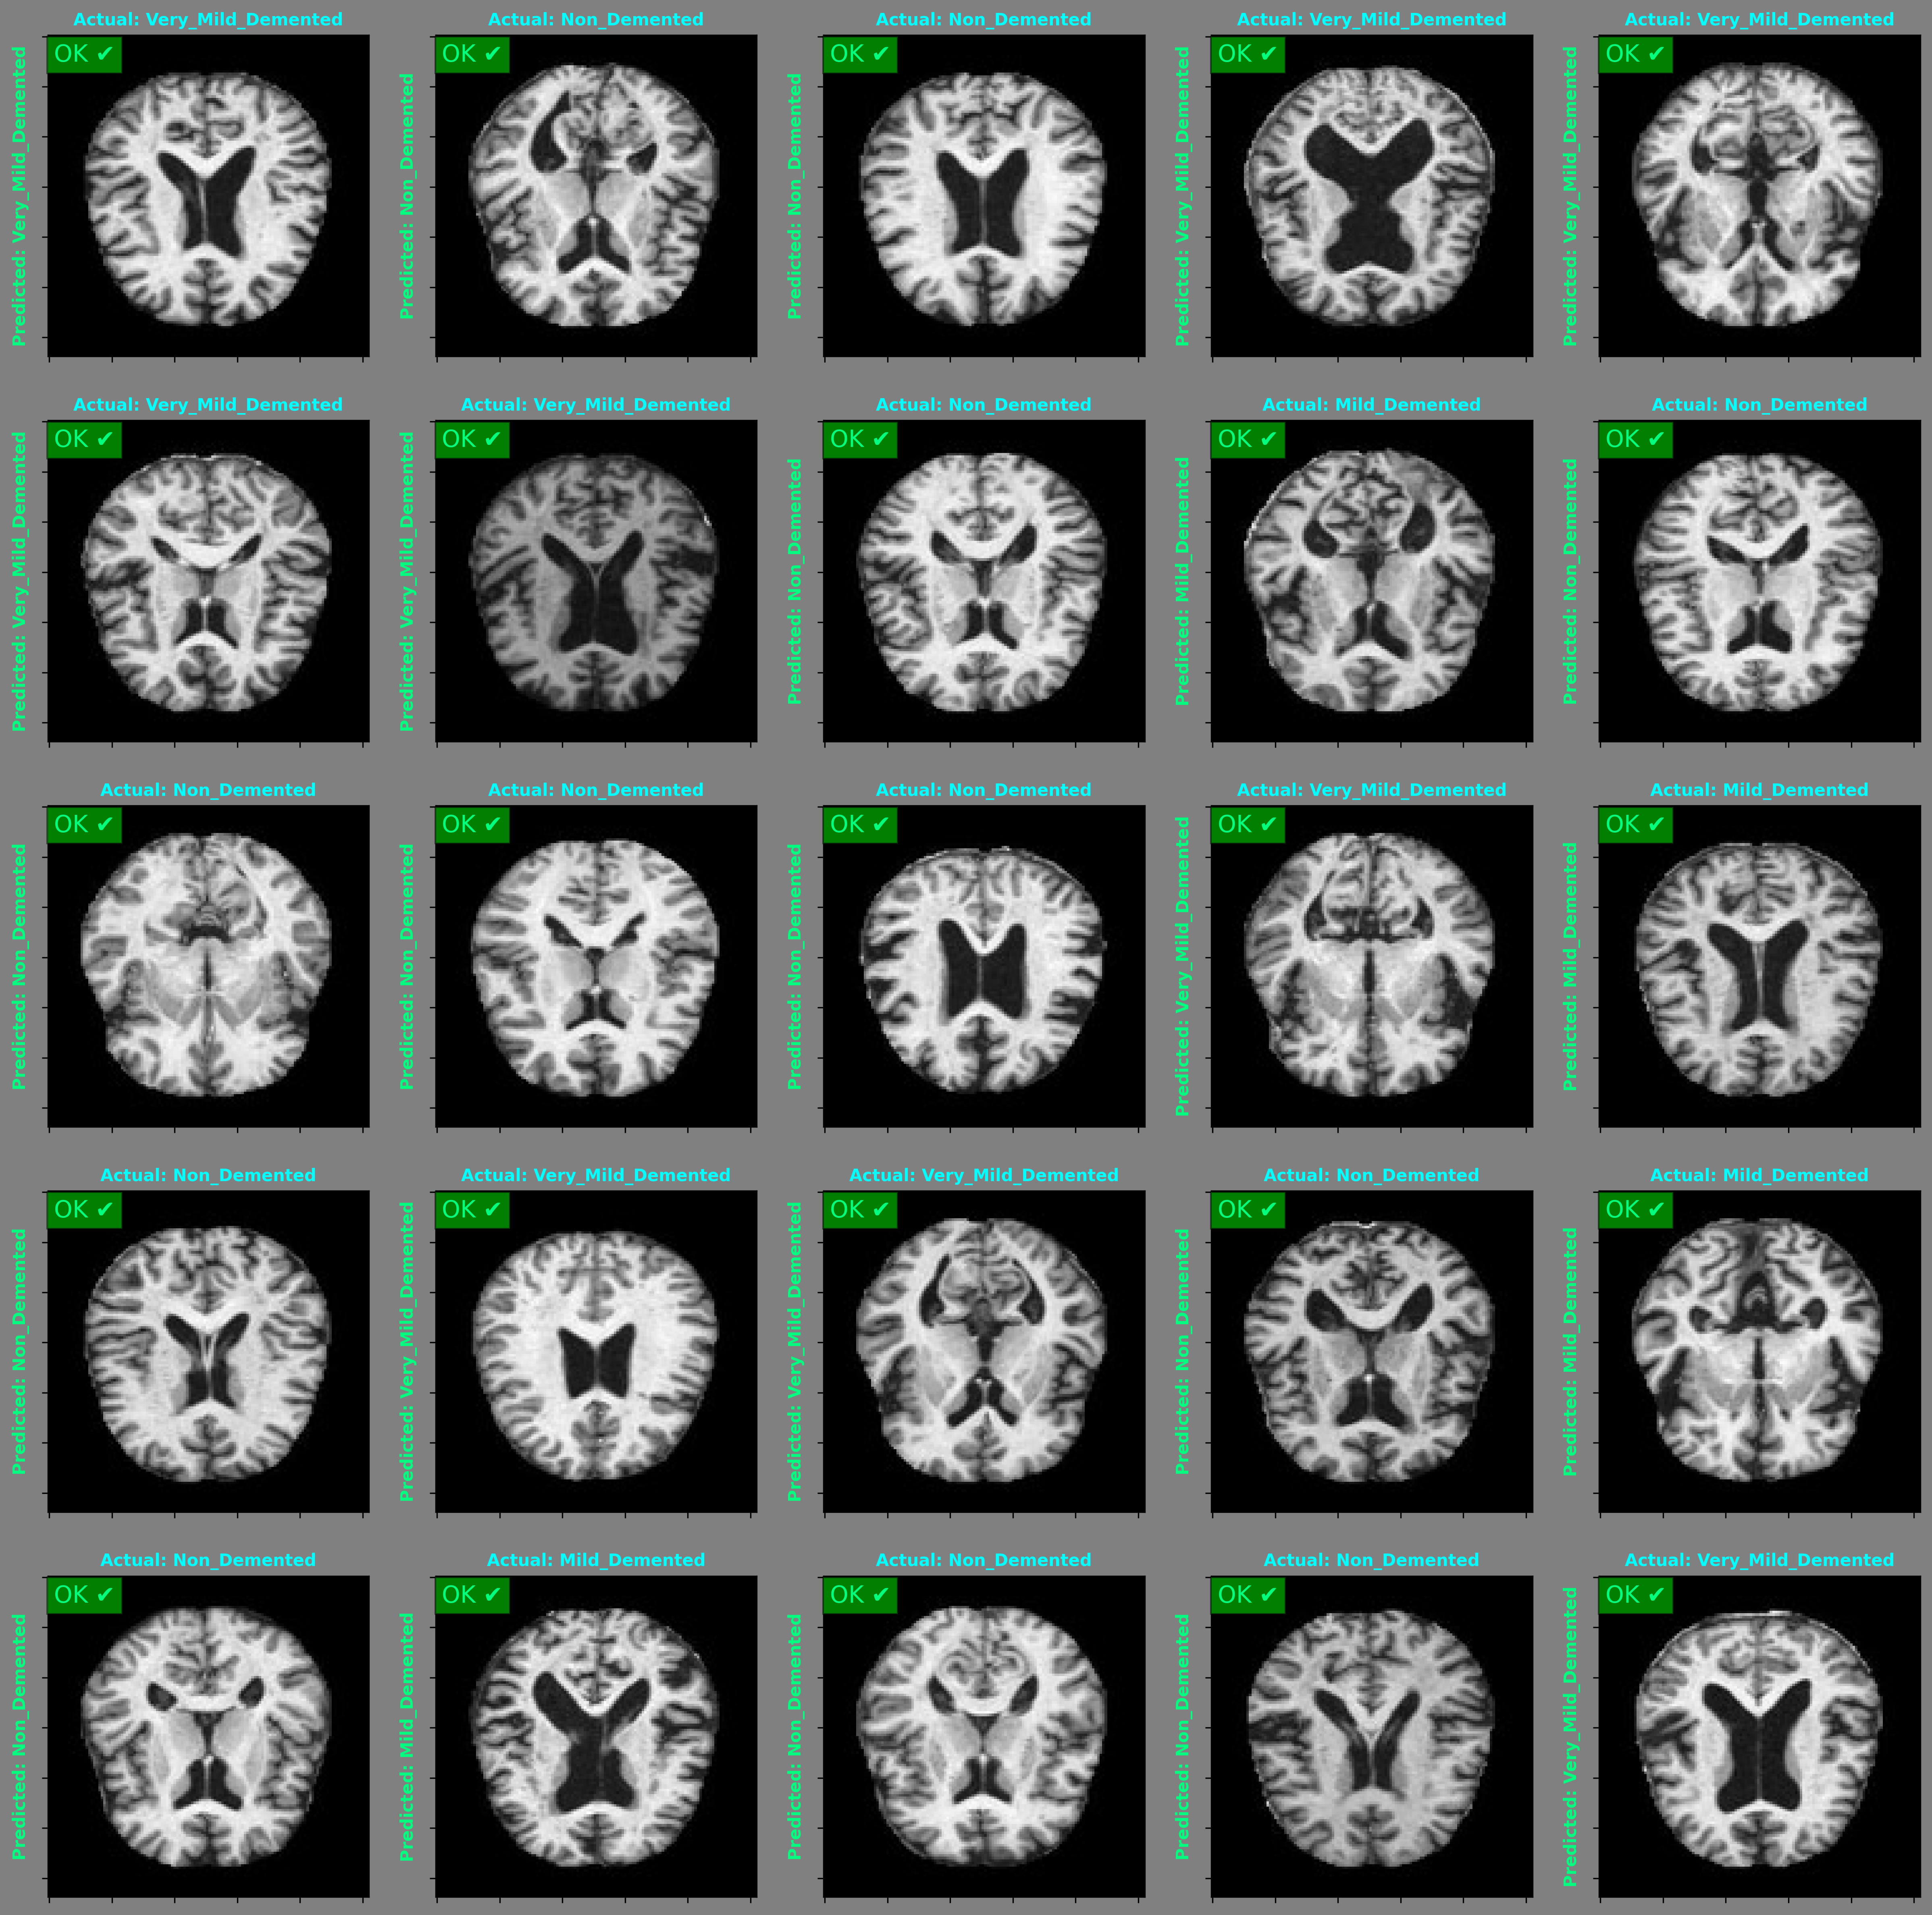

In [48]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))
    
        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

## *Predicting for selected image*

In [74]:
from PIL import Image
import numpy as np

def predict_uploaded_image(image_path):
    image = Image.open(image_path)
    image = np.array(image.resize((224, 224))) / 255.0  # assuming your model takes 224x224 images
    pred = model.predict(tf.expand_dims(image, 0))[0]
    
    probs = list(tf.nn.softmax(pred).numpy()) 
    probs_dict = dict(zip(class_dist.keys(), probs))
    
    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4) 
    ax1.imshow(image)
    ax1.set_title('Brain MRI', color="yellow", fontweight="bold", fontsize=16)
    
    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])        
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('Alzheimer Probabilities', color="yellow", fontweight="bold", fontsize=16)


In [73]:
from ipywidgets import FileUpload
from IPython.display import display
import io

import os

def on_upload_change(change):
    image_data = change['new'][0]
    image = Image.open(io.BytesIO(image_data['content']))
    
    # Save the image to a file
    image_path = 'uploaded_image.jpg'
    image.save(image_path)
    
    predict_uploaded_image(image_path)

upload_button = FileUpload(accept='image/*', multiple=True)
upload_button.observe(on_upload_change, names='_counter')
display(upload_button)

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)